Label mapping: {'P1': 0, 'P2': 1, 'P3': 2, 'P4': 3}
XGBoost Accuracy: 0.9977

Classification Report:
              precision    recall  f1-score   support

          P1       0.99      0.97      0.98      1116
          P2       1.00      1.00      1.00     16765
          P3       0.97      0.99      0.98      1454
          P4       1.00      1.00      1.00      1200

    accuracy                           1.00     20535
   macro avg       0.99      0.99      0.99     20535
weighted avg       1.00      1.00      1.00     20535

XGBoost Accuracy: 0.9977

Classification Report:
              precision    recall  f1-score   support

          P1       0.99      0.97      0.98      1116
          P2       1.00      1.00      1.00     16765
          P3       0.97      0.99      0.98      1454
          P4       1.00      1.00      1.00      1200

    accuracy                           1.00     20535
   macro avg       0.99      0.99      0.99     20535
weighted avg       1.00      1.00  

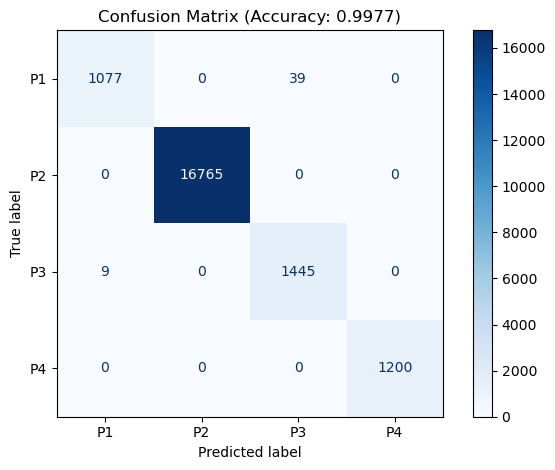

Model saved to: ../Artifacts/PLK\xgboost_model.json
Label mapping saved to: ../Artifacts/PLK\label_mapping.json
Feature columns saved to: ../Artifacts/PLK\training_columns.pkl

Predictions saved to: ../Artifacts/Predictions\prediction_results_xgboost.csv

Predictions saved to: ../Artifacts/Predictions\prediction_results_xgboost.csv


Feature column list saved to: ../Artifacts/PLK\training_columns.pkl


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML

# Load data
train_data = pd.read_csv("../Data/train_data.csv")
test_data = pd.read_csv("../Data/test_data.csv")

# Target column
target_column = "Approved_Flag"

# Columns to drop (leakage or identifiers)
leakage_columns = [
    target_column,
    "CreditRisk",
    "LoanStatus",
    "IsDefault",
    "RiskLevel",
    "CustomerID",
    "ID",
    "ApplicationID"
]

# Drop only columns that exist in the data
drop_cols = [col for col in leakage_columns if col in train_data.columns]

# Get input features
X_train_raw = train_data.drop(columns=drop_cols)
X_test_raw = test_data.drop(columns=drop_cols)

# Apply consistent encoding
combined = pd.concat([X_train_raw, X_test_raw], axis=0)
combined_encoded = pd.get_dummies(combined, drop_first=True)

# Split back into train and test sets
X_train = combined_encoded.iloc[:len(X_train_raw), :]
X_test = combined_encoded.iloc[len(X_train_raw):, :]

# Encode target labels
le = LabelEncoder()
y_train = le.fit_transform(train_data[target_column])
y_test = le.transform(test_data[target_column])

# Convert data to float32 and handle labels explicitly
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Encode target labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_data[target_column])
y_test_encoded = le.transform(test_data[target_column])

# Save label encoder mapping
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label mapping:", label_mapping)

# Train with explicit parameters
model = XGBClassifier(
    n_estimators=500,
    eval_metric='mlogloss',
    objective='multi:softmax',
    num_class=len(label_mapping),
    enable_categorical=False,  # Explicitly disable categorical encoding
    random_state=52
)

# Fit model with encoded labels
model.fit(X_train, y_train_encoded)

# Predict and decode results
y_pred = model.predict(X_test)
y_pred_labels = le.inverse_transform(y_pred)

# Build comparison DataFrame
comparison_df = test_data.copy()
comparison_df["Predicted"] = y_pred_labels
comparison_df["Correct"] = comparison_df[target_column] == comparison_df["Predicted"]

# Show accuracy and classification report
label_names = le.classes_.tolist()
accuracy = accuracy_score(y_test, y_pred)
print("XGBoost Accuracy:", round(accuracy, 4))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_names, zero_division=0))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    display_labels=label_names,
    cmap='Blues'
)
plt.title(f"Confusion Matrix (Accuracy: {round(accuracy, 4)})")
plt.tight_layout()
plt.show()

# Save model and metadata
import json
model_dir = "../Artifacts/PLK"
os.makedirs(model_dir, exist_ok=True)

# Save XGBoost model
model_path = os.path.join(model_dir, "xgboost_model.json")
model.save_model(model_path)

# Save label mapping
label_path = os.path.join(model_dir, "label_mapping.json")
with open(label_path, 'w') as f:
    json.dump(label_mapping, f)

# Save feature names
columns_path = os.path.join(model_dir, "training_columns.pkl")
with open(columns_path, 'wb') as f:
    pickle.dump(X_train.columns.tolist(), f)

print(f"Model saved to: {model_path}")
print(f"Label mapping saved to: {label_path}")
print(f"Feature columns saved to: {columns_path}")

# Add readable risk descriptions
def flag_to_risk(flag):
    if flag == "P1":
        return "Low Risk - Likely Approved"
    elif flag == "P2":
        return "Medium Risk - Review Needed"
    elif flag == "P3":
        return "High Risk - Likely Denied"
    elif flag == "P4":
        return "Critical Risk - Must Deny"
    return "Unknown"

comparison_df["Predicted_RiskLevel"] = comparison_df["Predicted"].apply(flag_to_risk)
comparison_df["Actual_RiskLevel"] = comparison_df[target_column].apply(flag_to_risk)

# Save predictions
predictions_dir = "../Artifacts/Predictions"
os.makedirs(predictions_dir, exist_ok=True)
csv_output_path = os.path.join(predictions_dir, "prediction_results_xgboost.csv")
comparison_df.to_csv(csv_output_path, index=False)
print(f"\nPredictions saved to: {csv_output_path}")

# Highlight incorrect predictions
def highlight_incorrect(row):
    return ['background-color: red; color: white' if not row['Correct'] else '' for _ in row]

preview_columns = ["Predicted", "Actual_RiskLevel", "Predicted_RiskLevel", "Correct", target_column]
preview_sample = comparison_df[preview_columns].sample(n=20, random_state=42).reset_index(drop=True)

styled_html = preview_sample.style.apply(highlight_incorrect, axis=1).to_html()
display(HTML(styled_html))

# Save training column names
plk_output_dir = "../Artifacts/PLK"
os.makedirs(plk_output_dir, exist_ok=True)
columns_output_path = os.path.join(plk_output_dir, "training_columns.pkl")
with open(columns_output_path, "wb") as f:
    pickle.dump(X_train.columns.tolist(), f)
print(f"Feature column list saved to: {columns_output_path}")